In [8]:
# Importar bibliotecas essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# Configurações de visualização (opcional)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# URL do dataset
url = "https://raw.githubusercontent.com/klaytoncastro/idp-machinelearning/refs/heads/main/datasets/telecom-customer-data.csv"

# Carregar o dataset
try:
    df = pd.read_csv(url)
    print("Dataset carregado com sucesso!")
    print(f"Forma do dataset: {df.shape}")
except Exception as e:
    print(f"Erro ao carregar o dataset: {e}")

Dataset carregado com sucesso!
Forma do dataset: (7043, 21)


In [9]:
# Visualizar primeiras linhas
print("\nPrimeiras 5 linhas do dataset:")
print(df.head())

# Informações básicas e tipos de dados
print("\nInformações do dataset:")
df.info()

# Tratar a coluna 'TotalCharges'
# Converter para numérico, substituindo espaços por NaN
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

# Preencher NaNs em 'TotalCharges' (gerados pela conversão ou já existentes) com a mediana
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
print("\n'TotalCharges' convertida para numérico e NaNs preenchidos.")

# Remover a coluna 'customerID' (não relevante para clusterização de perfil)
if 'customerID' in df.columns:
    df_cluster = df.drop('customerID', axis=1).copy() # Usar .copy() para evitar SettingWithCopyWarning
    print("\nColuna 'customerID' removida.")
else:
    df_cluster = df.copy()


# Verificar valores ausentes restantes
print("\nValores ausentes por coluna (após limpeza inicial):")
print(df_cluster.isnull().sum())
# Se houver outros NaNs, trate-os aqui (ex: df_cluster.dropna(inplace=True) ou preenchimento específico)


Primeiras 5 linhas do dataset:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV Stre

<ipython-input-9-a6ab1e59d070>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


In [10]:
# Identificar colunas numéricas e categóricas para pré-processamento
features_numericas = df_cluster.select_dtypes(include=np.number).columns.tolist()
features_categoricas = df_cluster.select_dtypes(include='object').columns.tolist()

# A coluna 'Churn' é categórica e pode ser interessante para analisar os clusters depois.
# Se 'Churn' estiver em features_categoricas, ela será codificada.
print(f"\nFeatures numéricas: {features_numericas}")
print(f"Features categóricas: {features_categoricas}")

# Criar o ColumnTransformer para aplicar transformações diferentes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), features_categoricas)
    ],
    remainder='passthrough' # Se houver colunas não especificadas (não deve haver aqui)
)

# Aplicar o pré-processamento
X_processed = preprocessor.fit_transform(df_cluster)

# Criar DataFrame com os dados processados e nomes de colunas corretos
try:
    feature_names_out = preprocessor.get_feature_names_out()
    X_processed_df = pd.DataFrame(X_processed, columns=feature_names_out)
    print("\nDataset pré-processado (primeiras linhas):")
    print(X_processed_df.head())
    print(f"Forma do dataset pré-processado: {X_processed_df.shape}")
except Exception as e:
    print(f"Erro ao obter nomes das features: {e}. Usando array NumPy.")
    X_processed_df = pd.DataFrame(X_processed) # Fallback se get_feature_names_out falhar


Features numéricas: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Features categóricas: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

Dataset pré-processado (primeiras linhas):
   num__SeniorCitizen  num__tenure  num__MonthlyCharges  num__TotalCharges  \
0           -0.439916    -1.277445            -1.160323          -0.994242   
1           -0.439916     0.066327            -0.259629          -0.173244   
2           -0.439916    -1.236724            -0.362660          -0.959674   
3           -0.439916     0.514251            -0.746535          -0.194766   
4           -0.439916    -1.236724             0.197365          -0.940470   

   cat__gender_Male  cat__Partner_Yes  cat__Dependents_Yes  \
0               0.0               1.0                  0.0   
1        

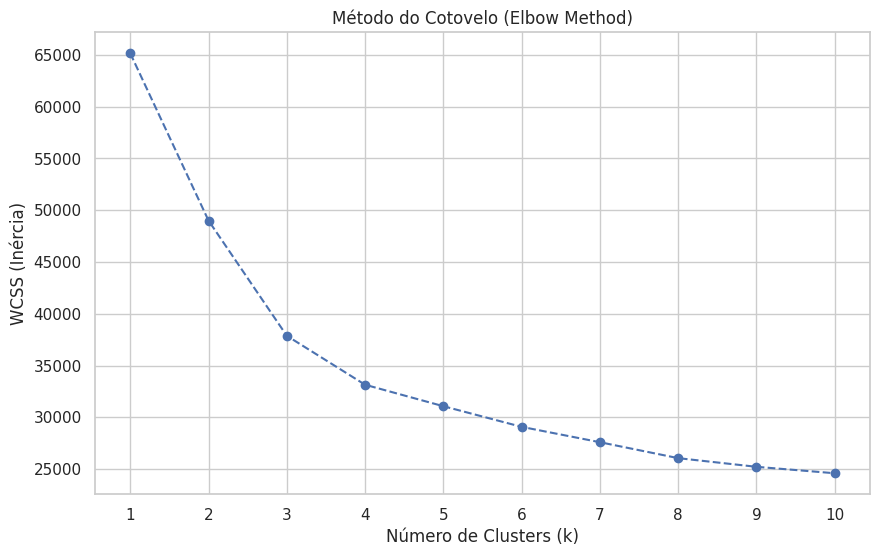

Analise o gráfico do Cotovelo: procure o 'cotovelo' onde a queda do WCSS desacelera.
Para k = 2, Coeficiente de Silhueta Médio: 0.2645
Para k = 3, Coeficiente de Silhueta Médio: 0.2586
Para k = 4, Coeficiente de Silhueta Médio: 0.2689
Para k = 5, Coeficiente de Silhueta Médio: 0.2172
Para k = 6, Coeficiente de Silhueta Médio: 0.2213
Para k = 7, Coeficiente de Silhueta Médio: 0.2083
Para k = 8, Coeficiente de Silhueta Médio: 0.1856
Para k = 9, Coeficiente de Silhueta Médio: 0.1716
Para k = 10, Coeficiente de Silhueta Médio: 0.1683


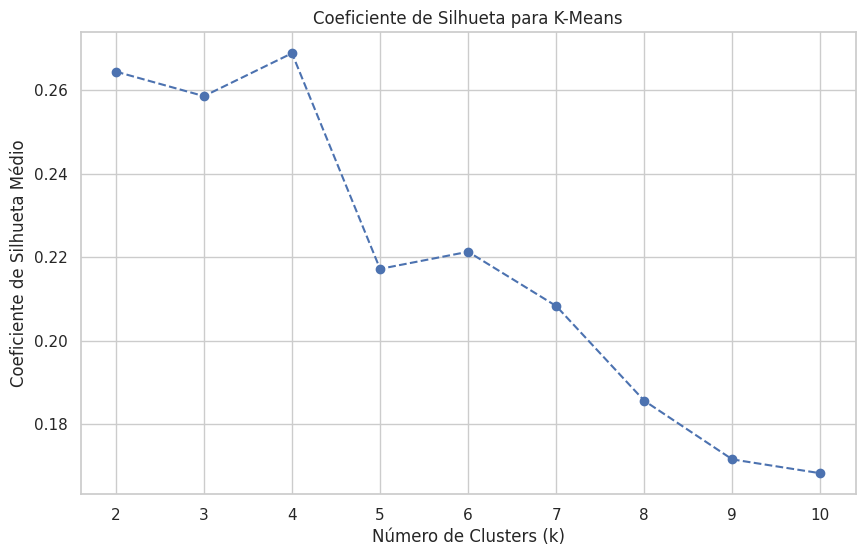

Analise o gráfico de Silhueta: procure o valor de 'k' com o maior score.


In [11]:
# 1. Método do Cotovelo (Elbow Method)
wcss = []
range_k = range(1, 11)
for i in range_k:
    kmeans_elbow = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42, algorithm='lloyd')
    kmeans_elbow.fit(X_processed_df)
    wcss.append(kmeans_elbow.inertia_)

plt.figure()
plt.plot(range_k, wcss, marker='o', linestyle='--')
plt.title('Método do Cotovelo (Elbow Method)')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('WCSS (Inércia)')
plt.xticks(range_k)
plt.grid(True)
plt.show()
print("Analise o gráfico do Cotovelo: procure o 'cotovelo' onde a queda do WCSS desacelera.")

# 2. Coeficiente de Silhueta
silhouette_scores = []
range_k_silhouette = range(2, 11) # Silhouette score requer pelo menos 2 clusters
for i in range_k_silhouette:
    kmeans_silhouette = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42, algorithm='lloyd')
    cluster_labels_temp = kmeans_silhouette.fit_predict(X_processed_df)
    silhouette_avg = silhouette_score(X_processed_df, cluster_labels_temp)
    silhouette_scores.append(silhouette_avg)
    print(f"Para k = {i}, Coeficiente de Silhueta Médio: {silhouette_avg:.4f}")

plt.figure()
plt.plot(range_k_silhouette, silhouette_scores, marker='o', linestyle='--')
plt.title('Coeficiente de Silhueta para K-Means')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Coeficiente de Silhueta Médio')
plt.xticks(range_k_silhouette)
plt.grid(True)
plt.show()
print("Analise o gráfico de Silhueta: procure o valor de 'k' com o maior score.")

# Instrução: Com base nos gráficos acima, defina o valor de k_otimo.
# Exemplo: k_otimo = 3 (SUBSTITUA PELO VALOR OBSERVADO!)

In [14]:
k_otimo = 4
print(f"Número de clusters escolhido (k_otimo): {k_otimo}")

# Aplicar K-Means com o k_otimo
kmeans_final = KMeans(n_clusters=k_otimo, init='k-means++', n_init=10, random_state=42, algorithm='lloyd')
df_cluster['Cluster_KMeans'] = kmeans_final.fit_predict(X_processed_df)

print("\nPrimeiras linhas do DataFrame com a coluna de Cluster:")
print(df_cluster.head())
print("\nContagem de clientes por cluster:")
print(df_cluster['Cluster_KMeans'].value_counts().sort_index())

Número de clusters escolhido (k_otimo): 4

Primeiras linhas do DataFrame com a coluna de Cluster:
   gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  ...  \
0  No phone service             DSL             No          Yes  ...   
1                No             DSL            Yes           No  ...   
2                No             DSL            Yes          Yes  ...   
3  No phone service             DSL            Yes           No  ...   
4                No     Fiber optic             No           No  ...   

  TechSupport StreamingTV StreamingMovies        Contract Pa


Características médias (numéricas) por cluster:
                SeniorCitizen     tenure  MonthlyCharges  TotalCharges  \
Cluster_KMeans                                                           
0                    0.061333  59.387200       89.552800   5313.582160   
1                    0.000000  15.786652       66.718504   1032.434468   
2                    0.034076  30.547182       21.079194    668.099443   
3                    1.000000  28.636923       80.102564   2395.437846   

                Churn_numeric  
Cluster_KMeans                 
0                    0.120000  
1                    0.400450  
2                    0.074050  
3                    0.474872  


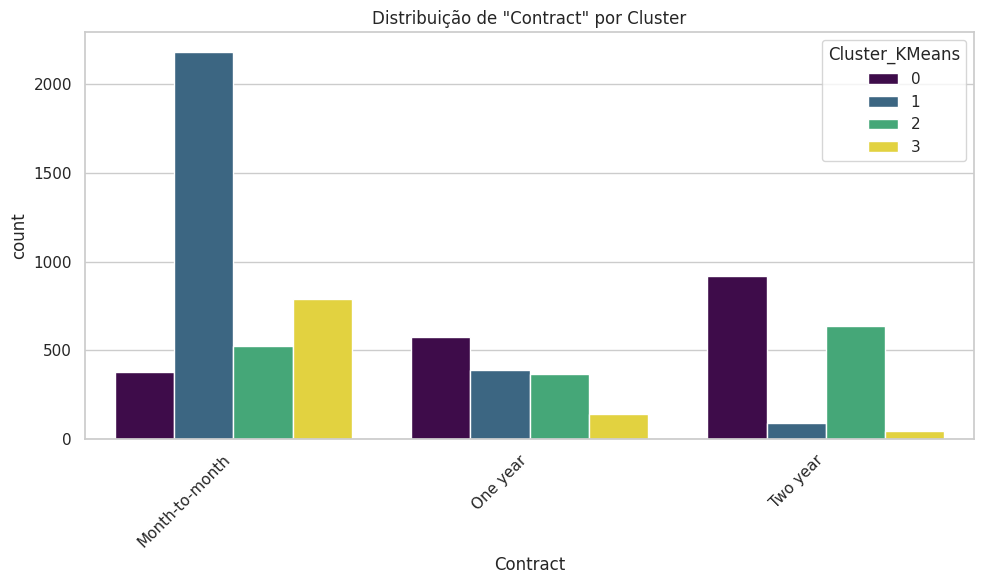

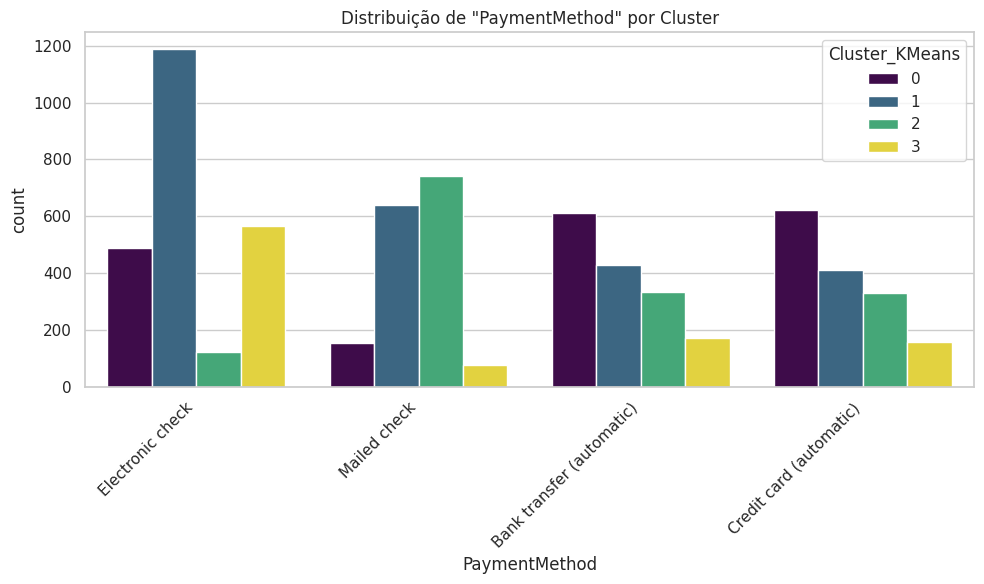

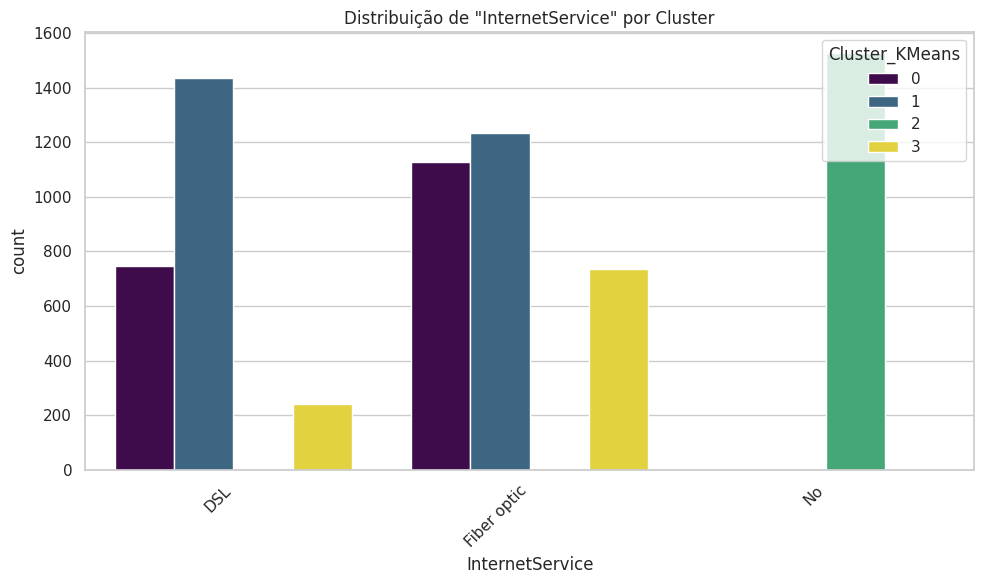

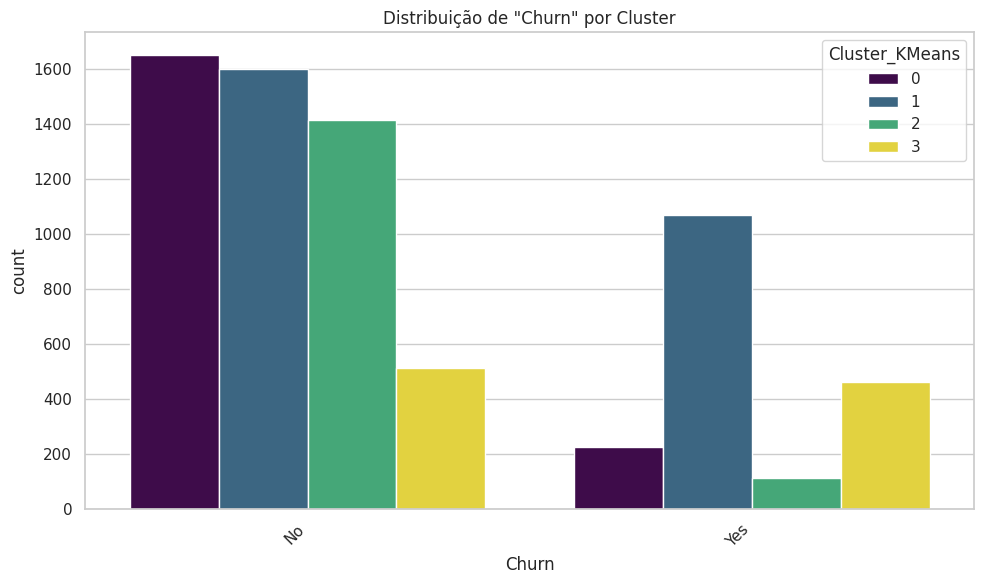

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


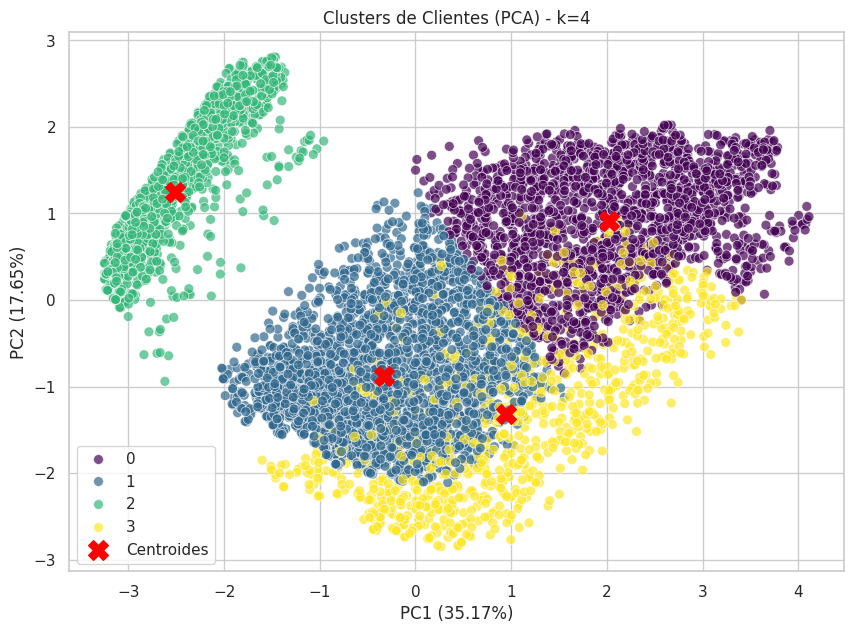


Interpretação:
Analise as tabelas de médias e os gráficos de contagem para entender o perfil de cada cluster.
Ex: Cluster 0 tem alta 'tenure' e baixa 'Churn_numeric'?
Ex: Qual o tipo de contrato predominante em cada cluster?


In [15]:
# Converter 'Churn' para numérico para facilitar a média (taxa de churn)
df_cluster['Churn_numeric'] = df_cluster['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# 1. Análise das features NUMÉRICAS médias por cluster
# Inclui 'Churn_numeric' para ver a taxa média de churn por cluster
features_analise_numericas = features_numericas + ['Churn_numeric']
cluster_summary_numeric = df_cluster.groupby('Cluster_KMeans')[features_analise_numericas].mean()
print("\nCaracterísticas médias (numéricas) por cluster:")
print(cluster_summary_numeric)

# 2. Análise de algumas features CATEGÓRICAS chave por cluster
# Exemplo com 'Contract' e 'PaymentMethod'. Adicione outras que julgar importantes.
features_analise_categoricas = ['Contract', 'PaymentMethod', 'InternetService', 'Churn'] # Usar 'Churn' original aqui para o countplot

for feature in features_analise_categoricas:
    plt.figure(figsize=(10,6))
    sns.countplot(data=df_cluster, x=feature, hue='Cluster_KMeans', palette='viridis')
    plt.title(f'Distribuição de "{feature}" por Cluster')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# 3. Visualização dos Clusters com PCA (Opcional, mas útil)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_processed_df) # Usa os dados processados

df_pca_plot = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca_plot['Cluster'] = df_cluster['Cluster_KMeans']

plt.figure(figsize=(10,7))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca_plot, palette='viridis', s=50, alpha=0.7)
centroids_pca = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, color='red', label='Centroides')
plt.title(f'Clusters de Clientes (PCA) - k={k_otimo}')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.legend()
plt.grid(True)
plt.show()

print("\nInterpretação:")
print("Analise as tabelas de médias e os gráficos de contagem para entender o perfil de cada cluster.")
print("Ex: Cluster 0 tem alta 'tenure' e baixa 'Churn_numeric'?")
print("Ex: Qual o tipo de contrato predominante em cada cluster?")

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score # Certifique-se que está importado
from sklearn.cluster import KMeans # Certifique-se que KMeans está importado

# Função de pontuação personalizada para o Silhouette Score no GridSearchCV
# O GridSearchCV irá ajustar o 'estimator' nos dados de treino de cada fold do CV.
# Esta função então usa o 'estimator' ajustado para prever clusters em 'X' (que será o conjunto de teste do fold)
# e calcula o silhouette score.
def silhouette_scorer_cv(estimator, X):
    labels = estimator.predict(X)
    if len(np.unique(labels)) < 2: # Silhouette score não é definido para < 2 clusters
        return -1.0 # Retorna um score baixo em vez de erro
    return silhouette_score(X, labels)

print("\n--- Otimização de Parâmetros do K-Means com GridSearchCV ---")

# Parâmetros para testar (incluindo 'algorithm' como no seu código original)
param_grid_kmeans = {
    'n_clusters': [2, 3, 4, 5],    # Testar os 'k' mais promissores
    'init': ['k-means++', 'random'],
    'n_init': [5, 10],             # Número de inicializações
    'max_iter': [300, 500],        # Máximo de iterações por inicialização
    'algorithm': ['lloyd']         # O algoritmo 'elkan' é mais rápido mas tem restrições.
                                   # 'lloyd' é o padrão e mais geral.
                                   # Se você removeu 'elkan' por erros anteriores, pode mantê-lo fora.
                                   # Se X_processed_df for um DataFrame Pandas denso, 'elkan' pode funcionar.
                                   # Se for uma matriz esparsa, 'lloyd' (ou 'auto' que escolheria 'lloyd') é necessário.
                                   # Como X_processed_df é denso, 'elkan' poderia ser testado.
                                   # 'algorithm': ['lloyd', 'elkan'] # Se quiser testar 'elkan'
}

kmeans_gs_model = KMeans(random_state=42) # Modelo base para o GridSearchCV

# Configurar GridSearchCV com a função de pontuação personalizada
grid_search = GridSearchCV(estimator=kmeans_gs_model,
                           param_grid=param_grid_kmeans,
                           scoring=silhouette_scorer_cv, # Usar a função personalizada
                           cv=2, # Cross-validation (2 ou 3 folds é razoável para começar)
                                 # Aumentar cv melhora a robustez, mas aumenta o tempo.
                           verbose=1,
                           n_jobs=-1) # Usar todos os processadores disponíveis

print("Iniciando GridSearchCV para K-Means (pode levar alguns minutos)...")
# X_processed_df é o nosso conjunto de dados pré-processado
grid_search.fit(X_processed_df)

print("\nMelhores hiperparâmetros encontrados pelo GridSearchCV:")
print(grid_search.best_params_)
print(f"Melhor Coeficiente de Silhueta (via GridSearchCV): {grid_search.best_score_:.4f}")

# Exemplo de como usar o melhor modelo encontrado:
# best_kmeans_from_gs = grid_search.best_estimator_
# df_cluster['Cluster_GridSearch'] = best_kmeans_from_gs.fit_predict(X_processed_df)
# print("\nContagem de clientes por cluster (usando modelo do GridSearchCV):")
# print(df_cluster['Cluster_GridSearch'].value_counts().sort_index())


--- Otimização de Parâmetros do K-Means com GridSearchCV ---
Iniciando GridSearchCV para K-Means (pode levar alguns minutos)...
Fitting 2 folds for each of 32 candidates, totalling 64 fits

Melhores hiperparâmetros encontrados pelo GridSearchCV:
{'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 4, 'n_init': 5}
Melhor Coeficiente de Silhueta (via GridSearchCV): 0.2684
